# pvlib-Python Forecasting (Albuquerque, NM)
### Install Standard Release 

In [1]:
# pip Upgrade
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=1)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


### Create Model

In [4]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_high_cloud_Mixed_intervals_Average  \
2020-06-15 06:00:00-06:00                                               98.0      
2020-06-15 09:00:00-06:00                                              100.0      
2020-06-15 12:00:00-06:00                                              100.0      
2020-06-15 15:00:00-06:00                                                6.0      
2020-06-15 18:00:00-06:00                                               23.0      

                           Total_cloud_cover_low_cloud_Mixed_intervals_Average  \
2020-06-15 06:00:00-06:00                                                0.0     
2020-06-15 09:00:00-06:00                                                0.0     
2020-06-15 12:00:00-06:00                                                0.0     
2020-06-15 15:00:00-06:00                                                0.0     
2020-06-15 18:00:00-06:00                                                0.0     

        

### Process Data with pvlib

In [5]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-15 06:00:00-06:00  18.649994    3.950884    0.179395    0.000000   
2020-06-15 09:00:00-06:00  16.661713    1.599144  184.733515    6.412857   
2020-06-15 12:00:00-06:00  15.806152    2.753484  328.661942   17.657005   
2020-06-15 15:00:00-06:00  28.850006    4.252644  839.706769  619.383439   
2020-06-15 18:00:00-06:00  39.950012    3.630006  318.018981  363.877050   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-15 06:00:00-06:00    0.179395         100.0         0.0        68.0   
2020-06-15 09:00:00-06:00  180.993933         100.0         0.0        13.0   
2020-06-15 12:00:00-06:00  311.933393         100.0         0.0        15.0   
2020-06-15 15:00:00-06:00  288.497247           6.0         0.0         0.0   
2020-06-15 18:00:00-06:00  156.310624          23.0         0.0         0.0   

                           high_clouds  
2020-06-15 06:00:00-06:00  

### GFS'S Class

In [6]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-06-15 06:00:00-06:00  18.649994    3.950884    0.179395    0.000000   
2020-06-15 09:00:00-06:00  16.661713    1.599144  184.733515    6.412857   
2020-06-15 12:00:00-06:00  15.806152    2.753484  328.661942   17.657005   
2020-06-15 15:00:00-06:00  28.850006    4.252644  839.706769  619.383439   
2020-06-15 18:00:00-06:00  39.950012    3.630006  318.018981  363.877050   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-06-15 06:00:00-06:00    0.179395         100.0         0.0        68.0   
2020-06-15 09:00:00-06:00  180.993933         100.0         0.0        13.0   
2020-06-15 12:00:00-06:00  311.933393         100.0         0.0        15.0   
2020-06-15 15:00:00-06:00  288.497247           6.0         0.0         0.0   
2020-06-15 18:00:00-06:00  156.310624          23.0         0.0         0.0   

                           high_clouds  
2020-06-15 06:00:00-06:00  

## Cloud Cover & Radiation

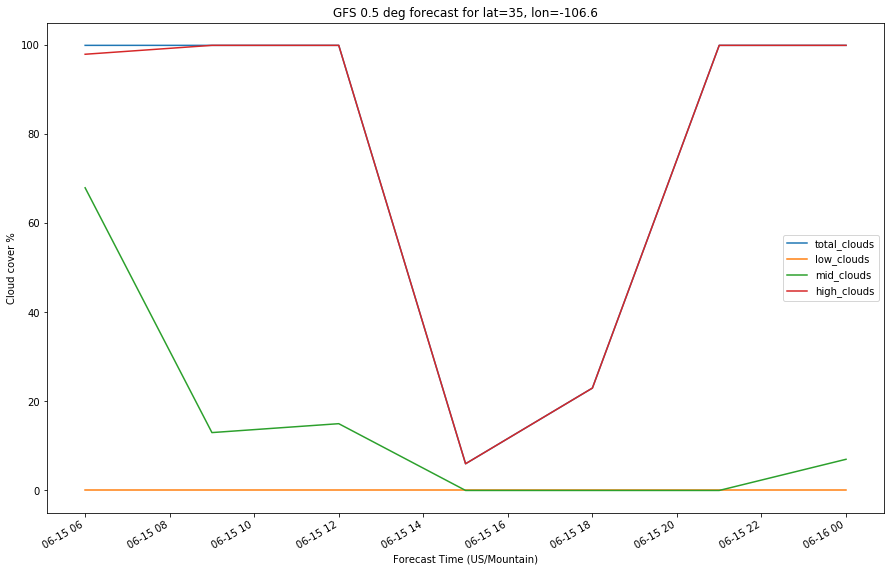

In [7]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

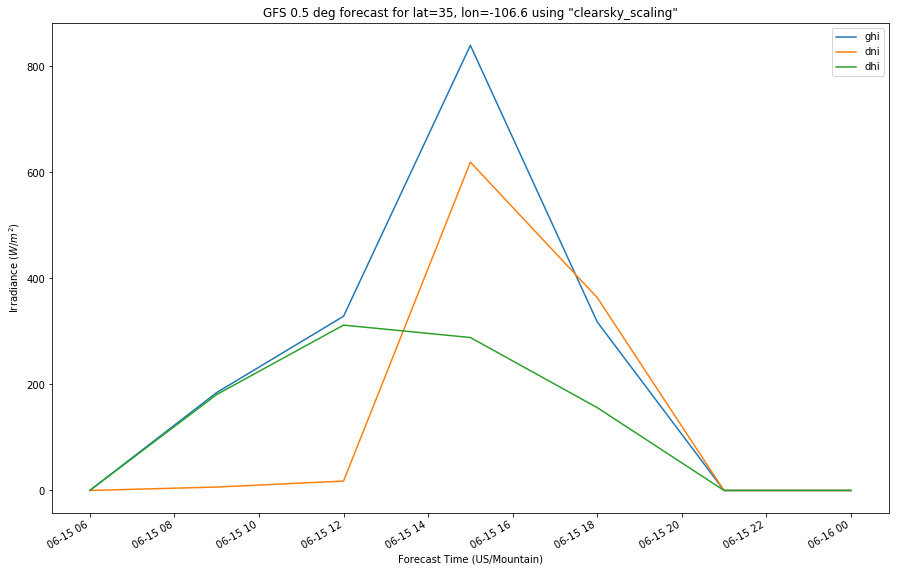

In [8]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

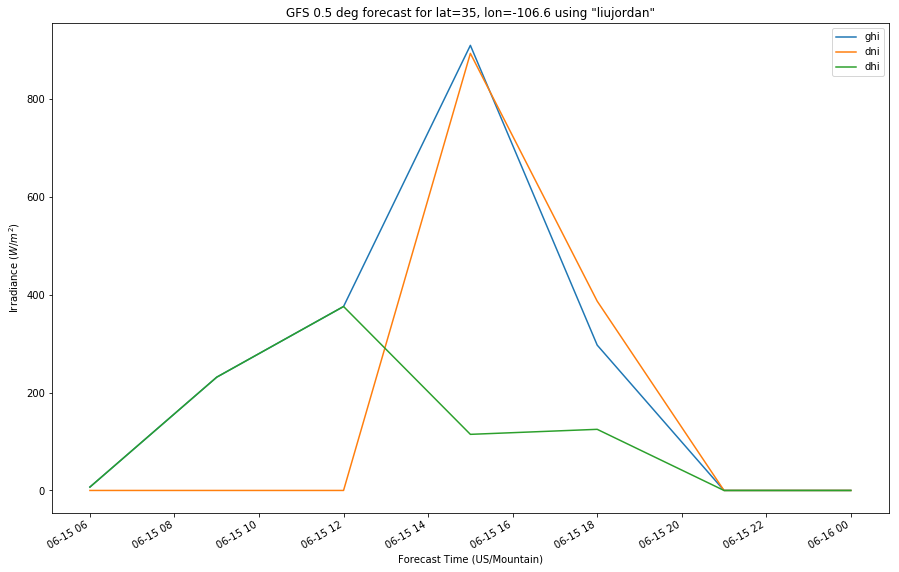

In [9]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

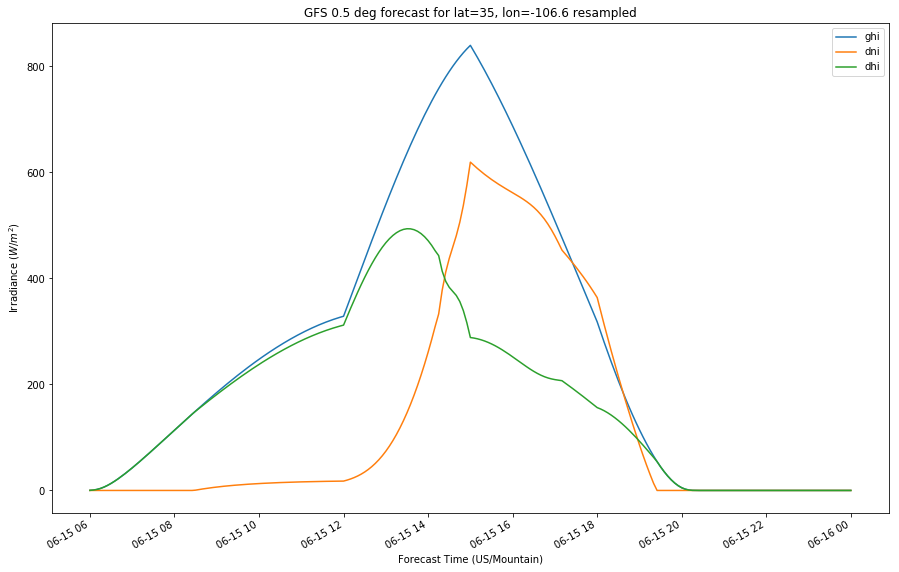

In [10]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

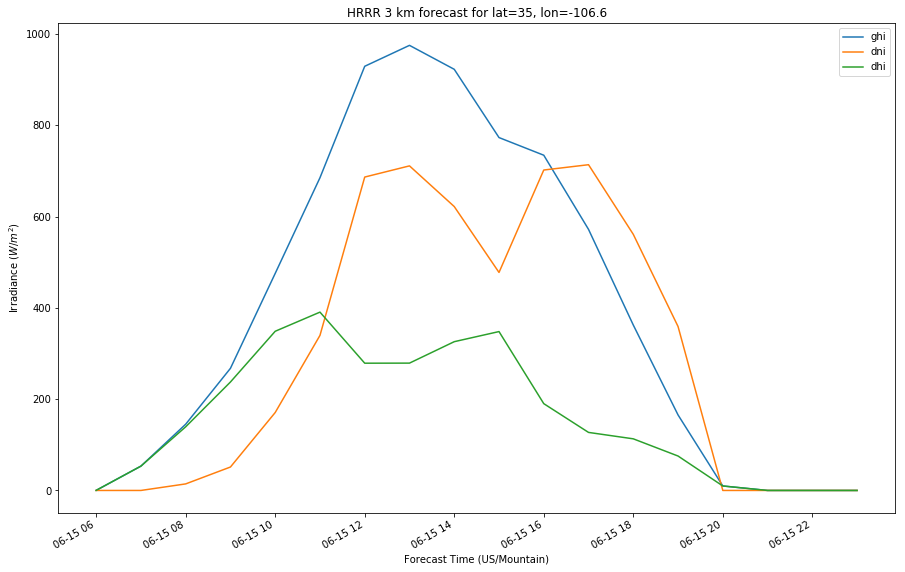

In [11]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

In [13]:
hrrr_data=data[irrad_vars]

### RAP

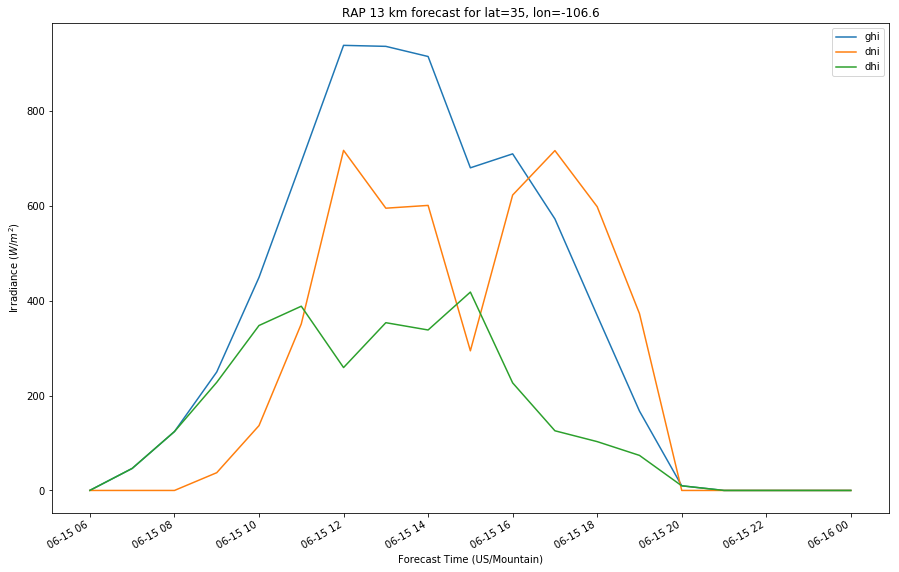

In [14]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

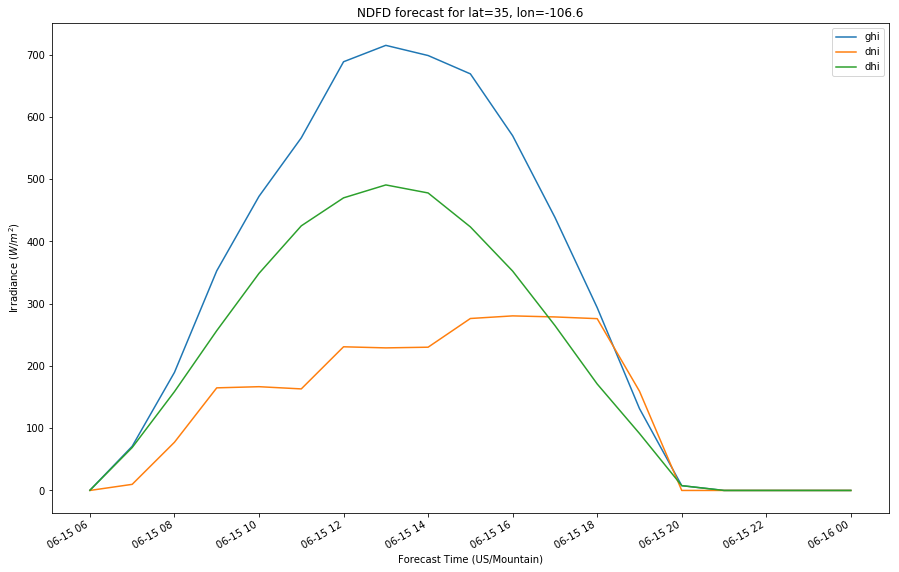

In [15]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [16]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['iPower__SHO_5_2__240V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=1)

# fx is a common abbreviation for forecast
fx_model = HRRR()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [17]:
invdb = pvsystem.retrieve_sam('CECInverter')
invdb

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.08961,2.24041,1.84651,1.95054,1.76944,1.84378,46.8638,67.7909,62.5547,18.1663,...,36.0334,2.5301,22.0954,24.4658,42.7765,31.682,64.7742,54.5701,85.1457,62.4867
Paco,250,250,300,300,300,300,10000,10000,12000,3000,...,3180,230,1100,2000,2500,3000,3500,4600,4800,5200
Pdco,259.589,259.492,311.669,311.581,312.421,312.005,10488.3,10296,12358.8,3142.3,...,3315.65,245.63,1194.09,2161.88,2632.84,3205.93,3641.84,4797.81,4968.03,5382.86
Vdco,40,40,40,40,45,45,320,362,370,310,...,375,40,182,199,218,222.5,263,254,263,280
C0,-4.1e-05,-3.9e-05,-3.3e-05,-3.4e-05,-4.5e-05,-3.5e-05,-2.7759e-06,-1.38839e-06,-1.009e-06,-8.03949e-06,...,-7.98467e-06,6.2e-05,-2.1e-05,-1.3e-05,-1.4e-05,-8.21046e-06,-9.08073e-06,-5.99928e-06,-6.16035e-06,-4.63524e-06
C1,-9.1e-05,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-3.6e-05,-4.9e-05,-5.6e-05,-1.1e-05,...,-7.5e-05,-9.8e-05,5.7e-05,5.5e-05,6.1e-05,3.6e-05,3.5e-05,2.8e-05,3.4e-05,4.4e-05
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


## ModelChain Attributes

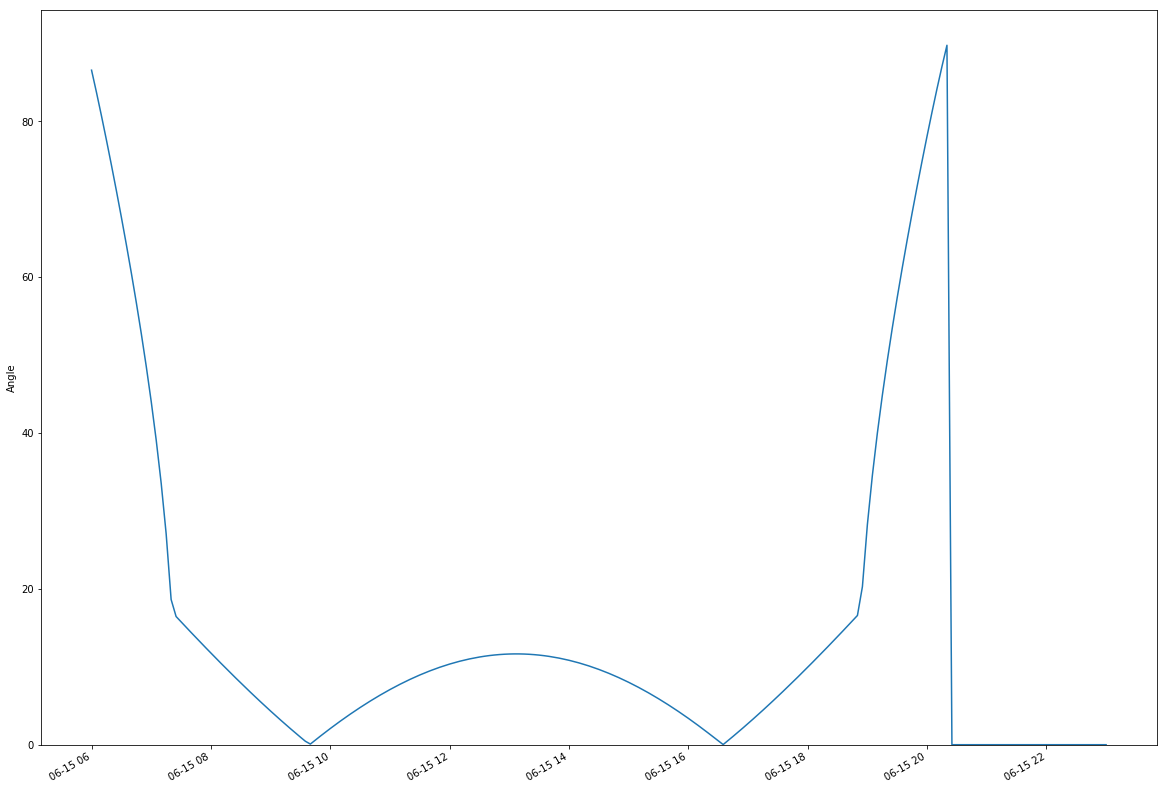

In [18]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

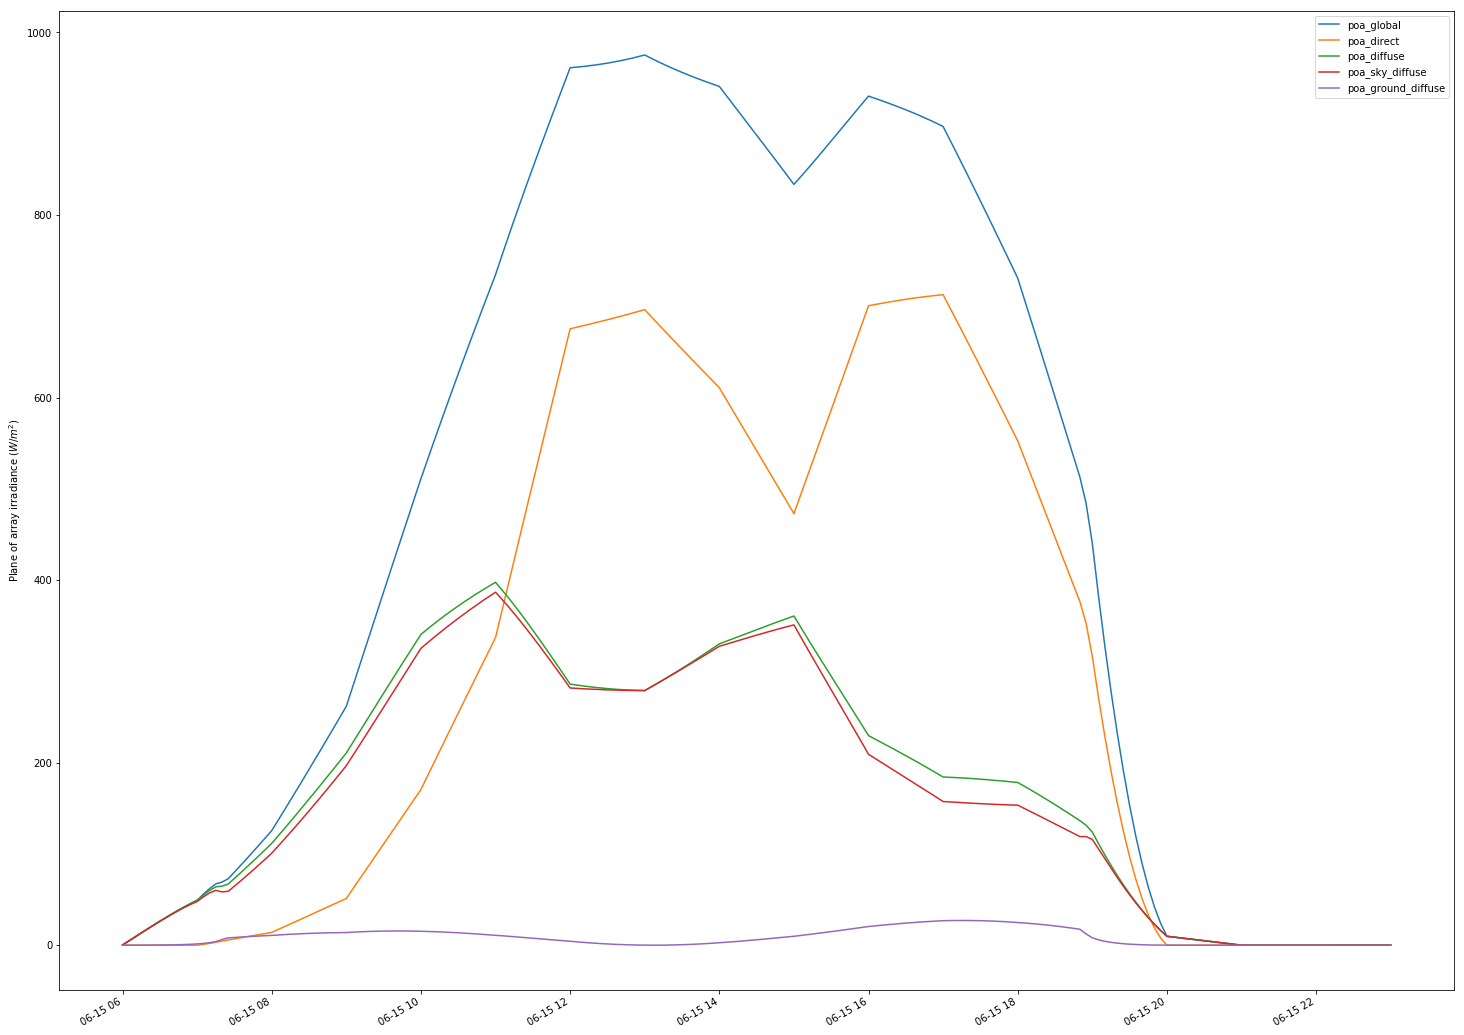

In [19]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

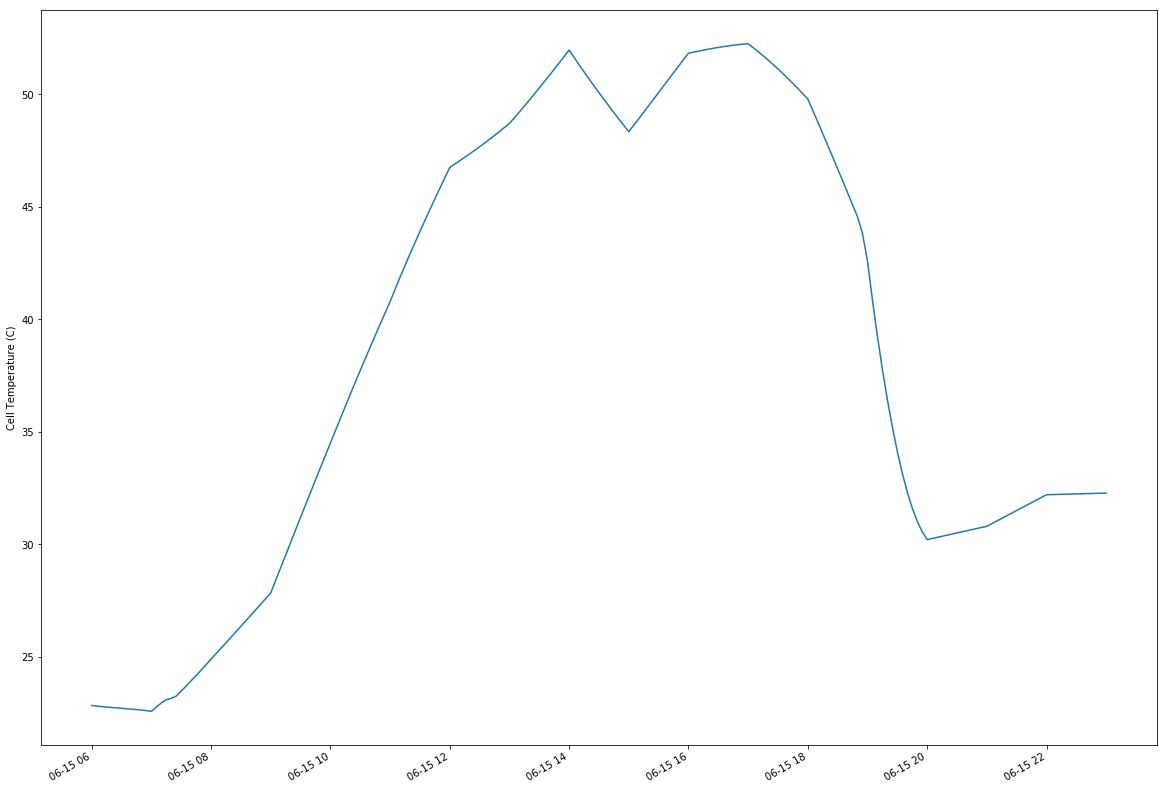

In [20]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

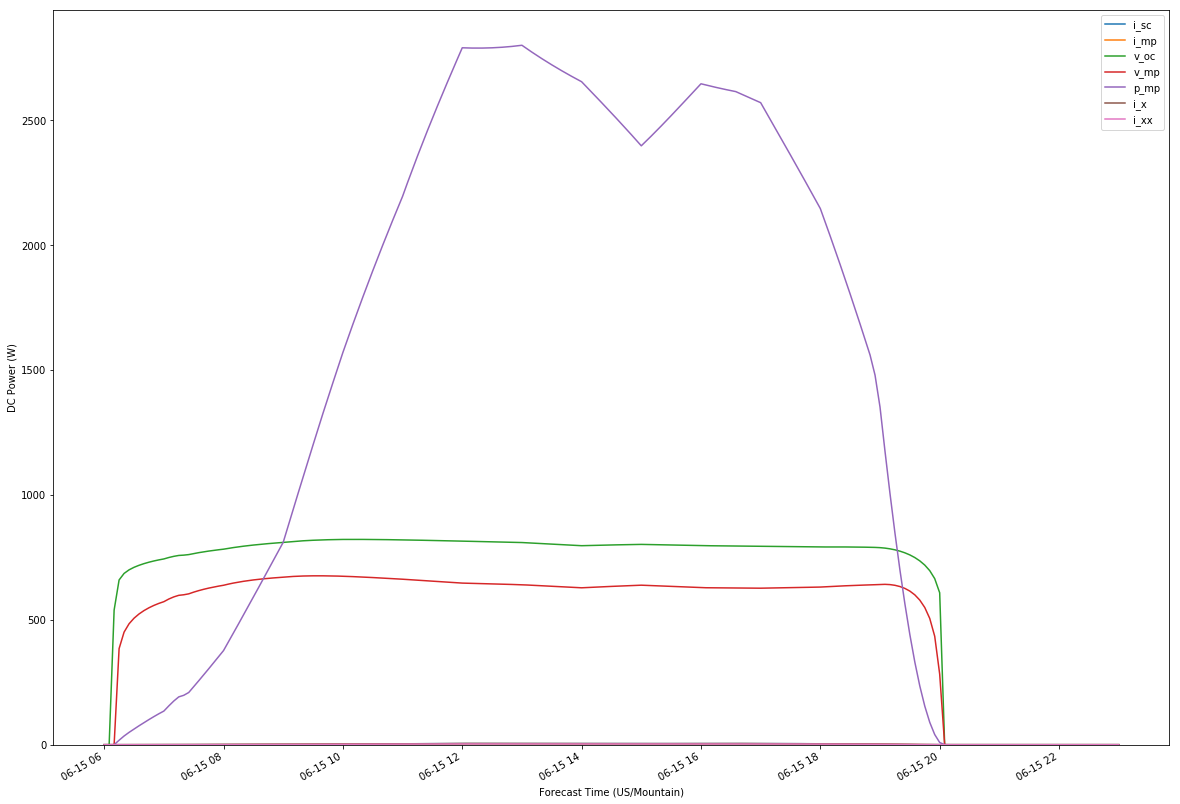

In [21]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [22]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,2.958150,2.636684,762.443223,603.316926,1688.570178,2.889050,1.913614
std,1.797409,1.595923,149.771260,133.819564,1016.260129,1.756683,1.128085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.051287,0.948017,789.248276,627.607069,627.552318,1.024609,0.739469
50%,3.621619,3.235546,797.739778,635.233246,2098.772766,3.536014,2.371021
75%,4.619215,4.107316,811.284141,649.602998,2591.959296,4.513094,2.938318
max,4.919398,4.373043,821.908297,676.166815,2800.143365,4.807392,3.100925


In [23]:
mc.dc.fillna(0).to_csv('DC June 16.csv', encoding='utf-8')

## MC AC Power

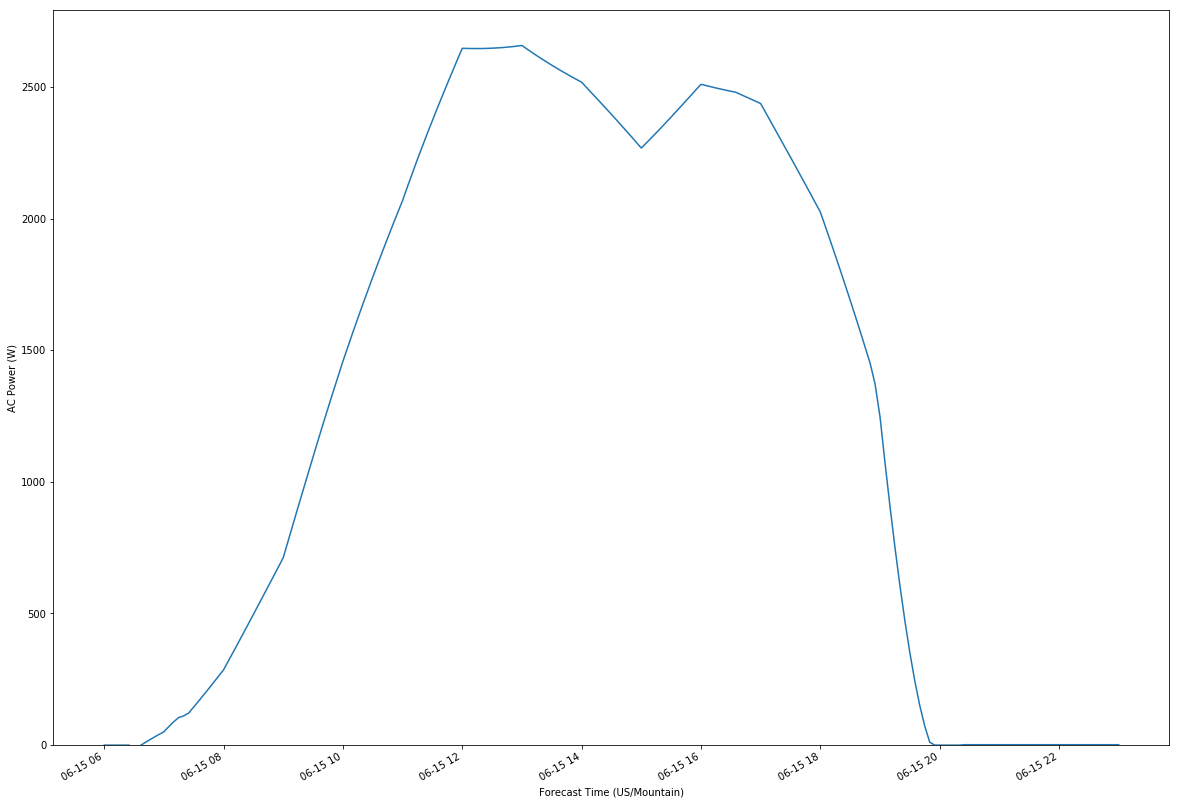

In [24]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [25]:
mc.ac.describe()

count     173.000000
mean     1576.941161
std       987.892441
min       -17.538506
25%       530.720726
50%      1974.249940
75%      2457.605821
max      2657.873657
dtype: float64

In [26]:
mc.ac.fillna(0)

2020-06-15 06:00:00-06:00     -1.560000
2020-06-15 06:05:00-06:00     -1.560000
2020-06-15 06:10:00-06:00     -1.560000
2020-06-15 06:15:00-06:00     -1.560000
2020-06-15 06:20:00-06:00     -1.560000
2020-06-15 06:25:00-06:00     -1.560000
2020-06-15 06:30:00-06:00    -17.538506
2020-06-15 06:35:00-06:00     -5.978653
2020-06-15 06:40:00-06:00      5.533654
2020-06-15 06:45:00-06:00     16.931047
2020-06-15 06:50:00-06:00     28.084107
2020-06-15 06:55:00-06:00     38.819524
2020-06-15 07:00:00-06:00     48.909542
2020-06-15 07:05:00-06:00     68.795716
2020-06-15 07:10:00-06:00     87.511712
2020-06-15 07:15:00-06:00    103.479988
2020-06-15 07:20:00-06:00    109.584574
2020-06-15 07:25:00-06:00    120.405369
2020-06-15 07:30:00-06:00    142.948851
2020-06-15 07:35:00-06:00    165.838589
2020-06-15 07:40:00-06:00    189.037558
2020-06-15 07:45:00-06:00    212.515359
2020-06-15 07:50:00-06:00    236.246646
2020-06-15 07:55:00-06:00    260.209968
2020-06-15 08:00:00-06:00    284.386894


In [27]:
mc.ac.fillna(0).to_csv('AC June 16.csv', encoding='utf-8')

### HRRR Irradiance Data

In [28]:
hrrr_data

,ghi,dni,dhi
2020-06-15 06:00:00-06:00,0.201883,0.000000,0.201883
2020-06-15 07:00:00-06:00,53.293137,0.000000,53.293137
2020-06-15 08:00:00-06:00,145.114537,14.337201,139.386353
2020-06-15 09:00:00-06:00,267.500708,51.339664,237.562585
2020-06-15 10:00:00-06:00,475.443246,170.716038,348.687823
2020-06-15 11:00:00-06:00,684.979840,339.636498,390.603156
2020-06-15 12:00:00-06:00,929.115552,686.480462,278.732174
2020-06-15 13:00:00-06:00,974.948386,710.951534,278.907128
2020-06-15 14:00:00-06:00,922.481105,621.850336,325.865352
2020-06-15 15:00:00-06:00,772.971480,477.518399,348.012283


In [29]:
hrrr_data.to_csv('HRRR June 16.csv', encoding='utf-8')